In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
# from numpy import infinity
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib .patches import Patch, Rectangle
from shapely.geometry import Point
from shapely.geometry import LineString

help = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")
commute = pd.read_csv(r"../data/dochadzka_zamestnanie_sodb_2001.csv", sep=";")
obce = gpd.read_file(r"../data/liptov_obce.csv", encoding = "windows-1250")
map2 = gpd.read_file(r"../data/geo/liptov.shp")
lipt_colors = pd.read_csv(r"../data/colors.csv", sep=";")
map2.drop(columns = ["DOW", "FACC", "IDN3", "NM3", "IDN2", "NM2", "NUTS1", "NUTS1_CODE", "NUTS2", "NUTS2_CODE", "NUTS3", "NUTS3_CODE", "LAU1", "LAU1_CODE", "LAU2", "LAU2_CODE", "VYMERA", "Shape_Area", "Shape_Leng"], inplace = True)
commute = (commute).rename(columns = {"Obec trvaleho pobytu": "obec_A", "Miesto pracoviska (obec)": "obec_B", "POCET": "pocet_01"})


help[["obecA", "obecB"]] = help[["obecA", "obecB"]].astype(str)
help["pocet"] = help["pocet"].astype(int)
help["flow"] = help[["obecA", "obecB"]].agg("-".join, axis = 1)
commute[["obec_A", "obec_B"]] = commute[["obec_A", "obec_B"]].astype(str)
commute["pocet_01"] = commute["pocet_01"].astype(int)
commute["flow"] = commute[["obec_A", "obec_B"]].agg("-".join, axis = 1)
lipt_colors["obec_id"] = lipt_colors["obec_id"].astype(str)
map2["IDN4"] = map2["IDN4"].astype(str)
obce["kod"] = obce["kod"].astype(str)
unique_obce = map2["IDN4"].apply(str).tolist()
commute = commute[commute["Periodicita dochadzky"] == 1]
commute = commute[commute["obec_A"].isin(unique_obce) & commute["obec_B"].isin(unique_obce)]
print(lipt_colors)

   obec_id            obec            color
0   510271      Beňadiková        mistyrose
1   510301        Bešeňová      deepskyblue
2   510319       Bobrovček        indianred
3   510327        Bobrovec            brown
4   510335       Bobrovník        firebrick
..     ...             ...              ...
76  511153          Vlachy          fuchsia
77  511170        Východná             navy
78  511188      Vyšná Boca       darkviolet
79  511196  Závažná Poruba  mediumvioletred
80  511200            Žiar        lightpink

[81 rows x 3 columns]


    obec_A  spolu  mimo_obce   v_obci  mimo_obce_percent  v_obci_percent  \
0   507300    150        131     19.0          87.333333       12.666667   
1   507393     75         72      3.0          96.000000        4.000000   
2   507407     51         43      8.0          84.313725       15.686275   
3   510262  11464       1413  10051.0          12.325541       87.674459   
4   510271    152        125     27.0          82.236842       17.763158   
..     ...    ...        ...      ...                ...             ...   
76  511196    418        351     67.0          83.971292       16.028708   
77  511200    137        122     15.0          89.051095       10.948905   
78  556807     28         24      4.0          85.714286       14.285714   
79  558281    328        250     78.0          76.219512       23.780488   
80  580287    515        460     55.0          89.320388       10.679612   

    independence  
0          False  
1          False  
2          False  
3          

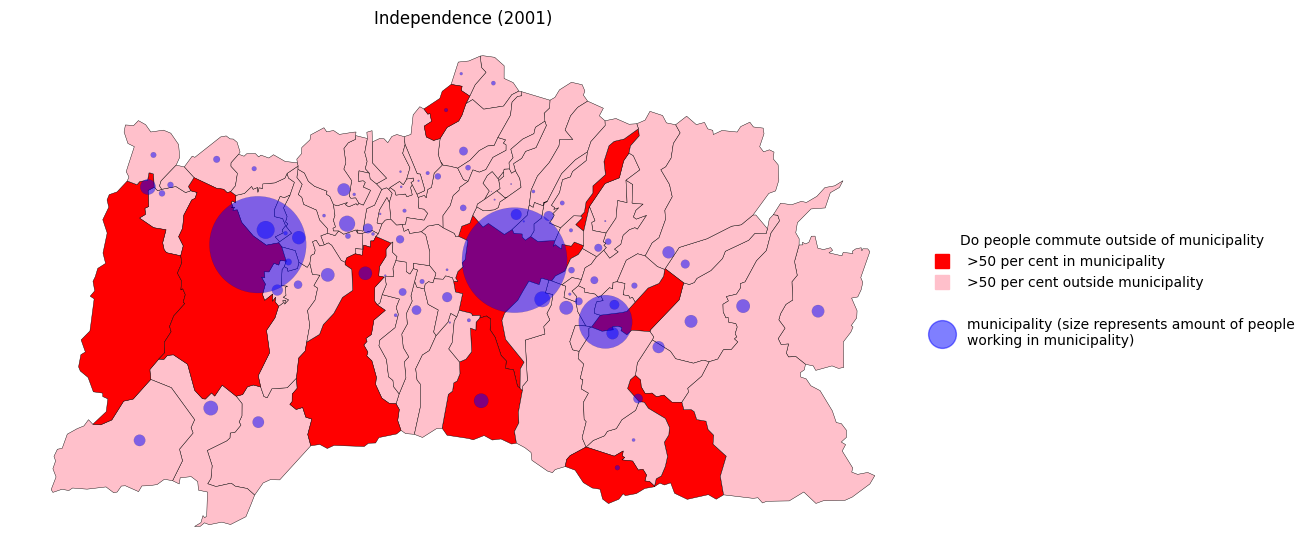

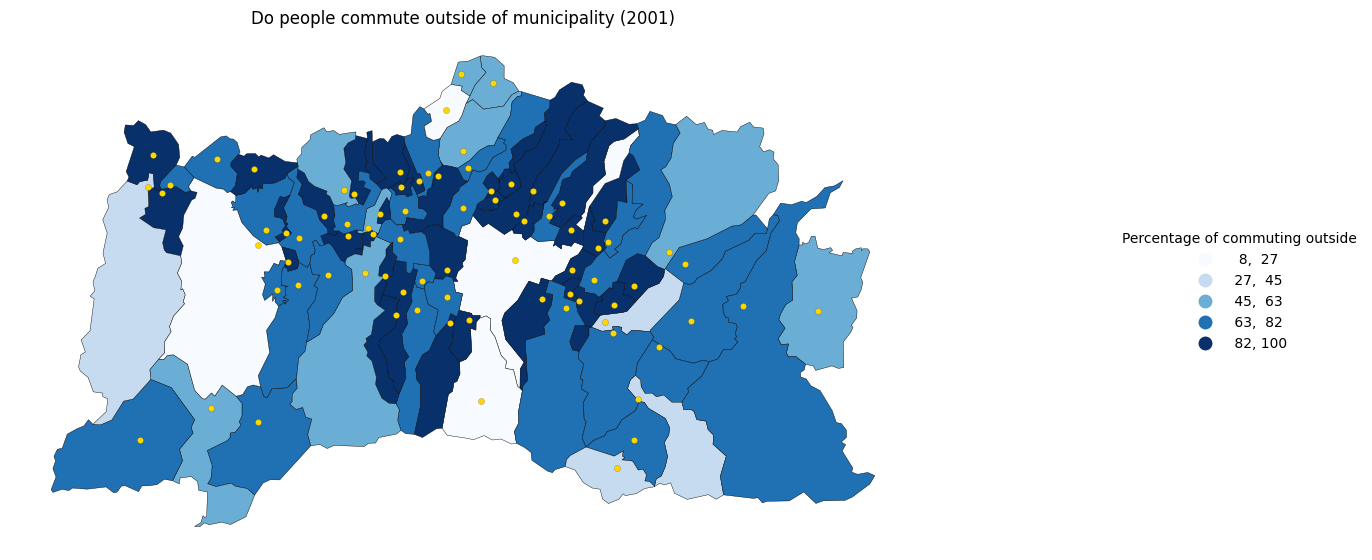

In [9]:
all = (
    commute
    .groupby("obec_A", group_keys = False)["pocet_01"]
    .sum()
)
outer = (
    commute[commute["obec_A"] != commute["obec_B"]]
    .groupby("obec_A", group_keys=False)["pocet_01"]
    .sum()
)
inter = (
    commute[commute["obec_A"] == commute["obec_B"]]
    .groupby("obec_A", group_keys=False)["pocet_01"]
    .sum()
)

all_df = all.reset_index().rename(columns = {"pocet_01": "spolu"})
inter_df = inter.reset_index().rename(columns = {"pocet_01": "v_obci"})
outer_df = outer.reset_index().rename(columns = {"pocet_01": "mimo_obce"})

table = all_df.merge(
    outer_df.merge(
    inter_df,
    on = "obec_A",
    how = "left"
), on = "obec_A", how = "left").fillna(0)
# print(outer.head())
# print(inter)

table["mimo_obce_percent"] = table["mimo_obce"]/table["spolu"]*100
table["v_obci_percent"] = table["v_obci"]/table["spolu"]*100
table["independence"] = table["v_obci"] > table["mimo_obce"]
print(table)
tablemap2 = map2.merge(
    table,
    left_on = "IDN4",
    right_on = "obec_A",
    how = "left"
)

# print(tablemap2)
color_dict_i = {True: "red", False: "pink"}
# print(obce.head())
comm = (commute.groupby("obec_B", group_keys = False)["pocet_01"].sum())
comm = comm.reset_index()
# print(comm.head())
obce_comm = obce.merge(
    comm,
    left_on = "kod",
    right_on = "obec_B",
    how = "left"
)
# print(tablemap2.head())

obce_gdf = gpd.GeoDataFrame(
    obce_comm,
    geometry=[Point(xy) for xy in zip(obce["x"], obce["y"])],
    crs="EPSG:5514"
)
# print(obce_gdf.head())

# ---------------- DOES THE MAJORITY OF PEOPLE IN WORKING AGE COMMUTE OUTSIDE OF MUNICIPALITY ---------------- 
plt.figure(figsize = (11.69, 8.27))
# plt.subplot(2, 1, 1)
tablemap2.plot(
    ax = plt.gca(),
    color = tablemap2["independence"].map(color_dict_i),
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "blue",
    markersize = obce_gdf["pocet_01"]/obce_gdf["pocet_01"].idxmax()*20,
    alpha = 0.5,
    edgecolor = "black",
    linewidth = 0.1
)
handles_i = [
    plt.Line2D(
        [0], [0],
        marker = "s",
        markersize = 10,
        linestyle = "None",
        color = color,
        # edgecolor = "black",
        label = ">50 per cent in municipality" if key else ">50 per cent outside municipality"
        )
        for key, color in color_dict_i.items()
]
handles_i.append(
    plt.Line2D(
        [0], [0],
        marker = "",
        color = "white",
        markersize = 20,
        linestyle = "None",
        label = ""
    )
)
handles_i.append(
    plt.Line2D(
        [0], [0],
        marker = "o",
        color = "blue",
        alpha = 0.5,
        markersize = 20,
        linestyle = "None",
        label = "municipality (size represents amount of people\nworking in municipality)"
    )
)
plt.legend(
    handles = handles_i,
    title = "Do people commute outside of municipality",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)

plt.title("Independence (2001)")
plt.axis(False)
# plt.savefig("../result_maps/autonomy/LM_RK_autonomy_2001_binary.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()
# ---------------- WHICH PERCENT OF PEOPLE DOES COMMUTE OUTSIDE OF MUNICIPALITY ---------------- 
plt.figure(figsize = (11.69, 8.27))
tablemap2["interval"] = pd.cut(tablemap2["mimo_obce_percent"], bins = 5, labels = False)
# plt.subplot(2, 1, 2)
tablemap2.plot(
    ax = plt.gca(),
    column = "mimo_obce_percent",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "equalinterval",
    k = 5,
    legend_kwds = {
        "title": "Percentage of commuting outside",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.title("Do people commute outside of municipality (2001)")
plt.axis(False)
# plt.savefig("../result_maps/autonomy/LM_RK_autonomy_2001.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

In [10]:
commute1 = commute.merge(
    map2,
    left_on = "obec_A",
    right_on = "IDN4",
    how = "right"
).rename(columns = {"NM4": "obecA_nazov"})
commuting = commute1.merge(
    map2,
    left_on = "obec_B",
    right_on = "IDN4",
    how = "right"
).rename(columns = {"NM4": "obecB_nazov"})
# print(commute1.head())
commuting = commuting.merge(
    lipt_colors,
    left_on = "obec_B",
    right_on = "obec_id",
    how = "left"
)
print(commuting.head())

   obec_A  obec_B  Periodicita dochadzky  pocet_01           flow  IDN4_x  \
0  507300  507300                      1        19  507300-507300  507300   
1  510262  507300                      1         2  510262-507300  510262   
2  510301  507300                      1         1  510301-507300  510301   
3  510530  507300                      1         1  510530-507300  510530   
4  510599  507300                      1         1  510599-507300  510599   

         obecA_nazov                                         geometry_x  \
0          Ivachnová  POLYGON Z ((-394781.2 -1189720.44 0, -394660.5...   
1  Liptovský Mikuláš  MULTIPOLYGON Z (((-384549.42 -1188431.31 0, -3...   
2           Bešeňová  POLYGON Z ((-391918.29 -1186162.77 0, -391612....   
3           Kalameny  POLYGON Z ((-393787.38 -1181708.03 0, -394017....   
4            Likavka  POLYGON Z ((-400702.7 -1185180.75 0, -400181.6...   

   IDN4_y obecB_nazov                                         geometry_y  \
0  507300 

In [11]:
# Most popular destinations (part 1)

# commuting = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")
map = gpd.read_file(r"../data/geo/liptov.shp")
okresy = gpd.read_file(r"../data/geo/liptov_okresy.shp")

# commuting[["obecA", "obecB"]] = commuting[["obecA", "obecB"]].astype(str)
map["IDN4"] = map["IDN4"].astype(str)



most_popular = (
    commuting[commuting["obec_A"] != commuting["obec_B"]]
    .groupby("obec_A", group_keys = False)[["obec_A", "obec_B", "obecB_nazov", "pocet_01", "color"]]
    .apply(lambda x: x.loc[x["pocet_01"].idxmax()])
    .reset_index(drop = True)
)

result = map.merge(
    most_popular[["obec_A", "obec_B", "obecB_nazov", "color"]],
    left_on = "IDN4",
    right_on = "obec_A",
    how = "left"
).rename(columns={"IDN4": "kod_start"})
unique_dest = result[["obecB_nazov", "color"]].drop_duplicates()
legend_patches1 = [
    mpatches.Patch(color = row["color"], label = row["obecB_nazov"])
    for _, row in unique_dest.iterrows()
]

most_popular2 = (
    commuting
    .groupby("obec_A", group_keys = False)[["obec_A", "obec_B", "obecB_nazov", "pocet_01", "color"]]
    .apply(lambda x: x.loc[x["pocet_01"].idxmax()])
    .reset_index(drop = True)
)

result2 = map.merge(
    most_popular2[["obec_A", "obec_B", "obecB_nazov", "color"]],
    left_on = "IDN4",
    right_on = "obec_A",
    how = "left"
).rename(columns={"IDN4": "kod_start"})
unique_dest2 = result2[["obecB_nazov", "color"]].drop_duplicates()
legend_patches2 = [
    mpatches.Patch(color = row["color"], label = row["obecB_nazov"])
    for _, row in unique_dest2.iterrows()
]

second_popular_50 = (
    commuting[commuting["obec_A"] != commuting["obec_B"]]
    .groupby("obec_A", group_keys = False)[["obec_A", "obec_B", "obecB_nazov", "pocet_01", "color"]]
    .apply(lambda x: x.nlargest(2, "pocet_01").iloc[-1] if len(x) > 1 and x.nlargest(2, "pocet_01")["pocet_01"].iloc[1] >= x.nlargest(2, "pocet_01")["pocet_01"].iloc[0] * 0.5 else None)
    .reset_index(drop=True)
).dropna()
result3 = map.merge(
    second_popular_50[["obec_A", "obec_B", "obecB_nazov", "color"]],
    left_on = "IDN4",
    right_on = "obec_A",
    how = "left"
).rename(columns = {"IDN4": "kod_start"})
unique_dest3 = result3[["obecB_nazov", "color"]].drop_duplicates()
unique_dest3["color"] = unique_dest3["color"].fillna("lightgray")
legend_patches3 = [
    mpatches.Patch(color = row["color"], label = row["obecB_nazov"])
    for _, row in unique_dest3.iterrows()
]

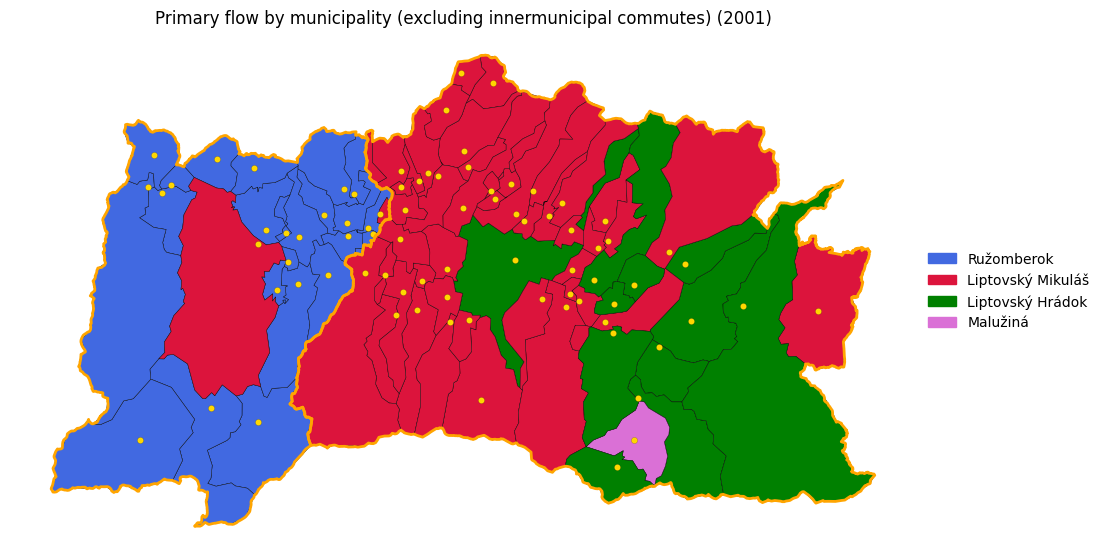

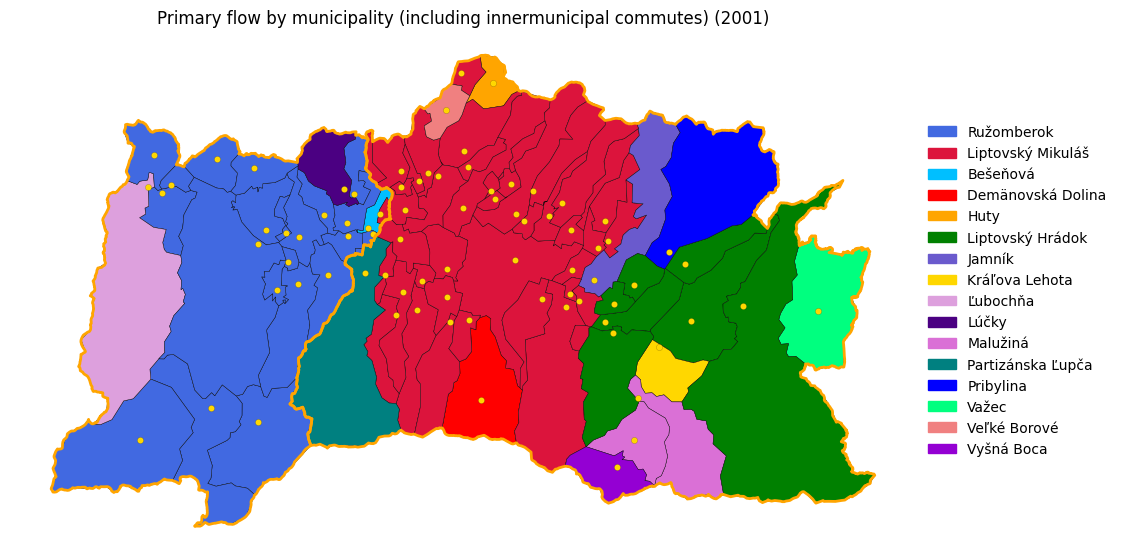

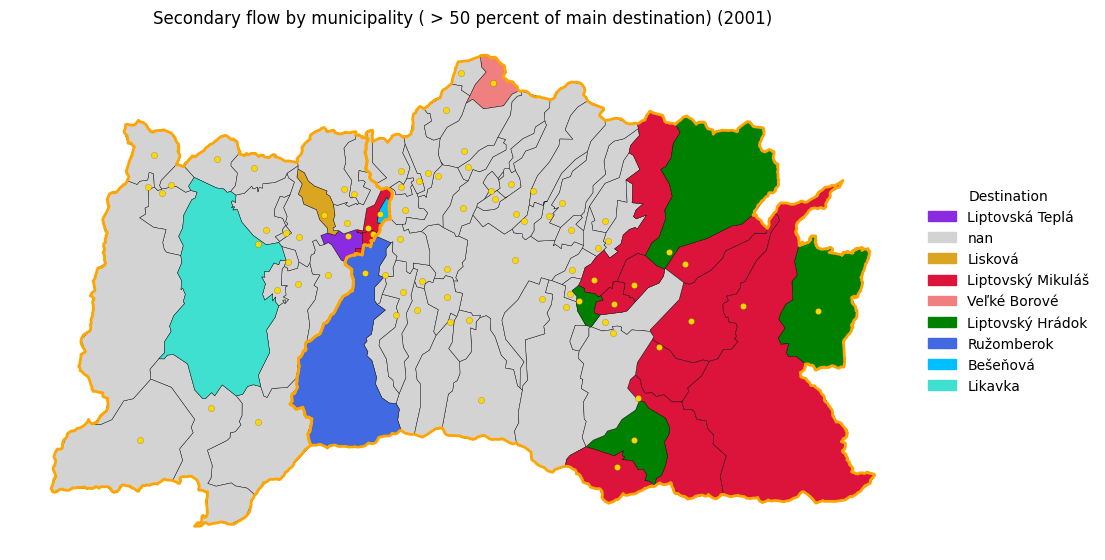

In [12]:
# (part 2)

plt.figure(figsize = (11.69, 8.27))
result.plot(
    ax = plt.gca(),
    color = result["color"].fillna("lightgray"),
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 2.0
)
plt.legend(
    handles = legend_patches1,
    # title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)
plt.title("Primary flow by municipality (excluding innermunicipal commutes) (2001)")
plt.axis(False)
# plt.savefig("../result_maps/popular/2001_most_popular.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()



plt.figure(figsize = (11.69, 8.27))
result2.plot(
    ax = plt.gca(),
    color = result2["color"].fillna("lightgray"),
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 2.0
)
plt.legend(
    handles = legend_patches2,
    # title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)
plt.title("Primary flow by municipality (including innermunicipal commutes) (2001)")
plt.axis(False)
# plt.savefig("../result_maps/popular/2001_most_popular_all.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()


plt.figure(figsize = (11.69, 8.27))
result3.plot(
    ax = plt.gca(),
    color = result3["color"].fillna("lightgray"),
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 2.0
)
plt.legend(
    handles = legend_patches3,
    title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False,
    # labelspacing = 1.25
)
plt.title("Secondary flow by municipality ( > 50 percent of main destination) (2001)")
plt.axis(False)
# plt.suptitle("Daily commuting patterns in Liptov region in 2021")
# plt.savefig("../result_maps/popular/2001_second_most_popular_50.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

<Figure size 827x1169 with 0 Axes>

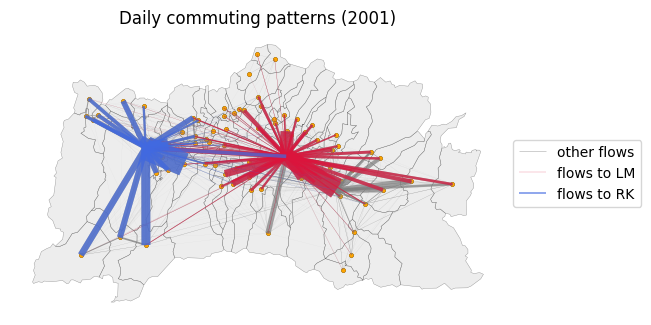

In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib .patches import Patch, Rectangle
from shapely.geometry import Point
from shapely.geometry import LineString

obce = gpd.read_file(r"../data/liptov_obce.csv", encoding = "windows-1250")

commuting["obec_A"] = commuting["obec_A"].astype(str)
commuting["obec_B"] = commuting["obec_B"].astype(str)
obce["kod"] = obce["kod"].astype(str)
commuting = commuting.merge(
    obce[["kod", "x", "y"]],
    left_on = "obec_A",
    right_on = "kod",
    how = "left"
).rename(columns={"x": "start_x", "y": "start_y", "kod": "kod_start"})

commuting = commuting.merge(
    obce[["kod", "x", "y"]],
    left_on = "obec_B",
    right_on = "kod",
    how = "left"
).rename(columns={"x": "end_x", "y": "end_y", "kod": "kod_dest"})
commuting_gdf = gpd.GeoDataFrame(
    commuting,
    geometry=[Point(xy) for xy in zip(commuting["start_x"], commuting["start_y"])],
    crs="EPSG:5514"
)
# print(commuting_gdf.head())

background = gpd.read_file(r"../data/geo/liptov.shp")

commuting["geometry"] = commuting.apply(
    lambda row: LineString([(row["start_x"], row["start_y"]), (row["end_x"], row["end_y"])]),
    axis = 1
)
line_gdf = gpd.GeoDataFrame(commuting, geometry = "geometry", crs="EPSG:5514")

flows_510262 = line_gdf[line_gdf["kod_dest"] == "510262"]
flows_510998 = line_gdf[line_gdf["kod_dest"] == "510998"]
flows_other = line_gdf
plt.figure(figsize = (8.27, 11.69))

ax = background.plot(
    alpha = 0.4,
    edgecolor = "black",
    color = "lightgray",
    linewidth = 0.3
)
flows_other.plot(
    ax = ax,
    linewidth = flows_other["pocet_01"]/50,
    alpha = 0.7,
    color = "grey",
    label = "other flows"
)
flows_510262.plot(
    ax = ax,
    linewidth = flows_510262["pocet_01"]/50,
    alpha = 0.7,
    color = "crimson",
    label = "flows to LM"
)

flows_510998.plot(
    ax = ax,
    linewidth = flows_510998["pocet_01"]/50,
    alpha = 0.7,
    color = "royalblue",
    label = "flows to RK"
)

obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.legend(
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = True
)

plt.title("Daily commuting patterns (2001)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis(False)

plt.grid(False)

obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.legend(
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = True
)

plt.title("Daily commuting patterns (2001)")
plt.axis(False)
plt.grid(False)

plt.savefig("../result_maps/flows/LM_RK_flows_2001.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

<Figure size 827x1169 with 0 Axes>

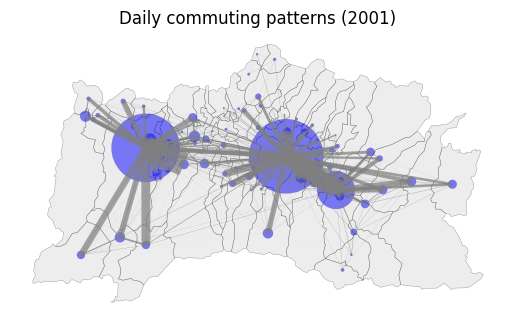

In [9]:
plt.figure(figsize = (8.27, 11.69))

ax = background.plot(
    alpha = 0.4,
    edgecolor = "black",
    color = "lightgray",
    linewidth = 0.3
)

flows_other.plot(
    ax = ax,
    linewidth = flows_other["pocet_01"]/50,
    alpha = 0.7,
    color = "grey",
    label = "other flows"
)
obce_gdf.plot(
    ax = ax,
    color = "blue",
    markersize = obce_gdf["pocet_01"]/obce_gdf["pocet_01"].idxmax()*10,
    alpha = 0.5,
    edgecolor = "black",
    linewidth = 0.1
)
plt.title("Daily commuting patterns (2001)")
plt.axis(False)
plt.grid(False)

plt.savefig("../result_maps/flows/all_LM_RK_flows_2001.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()
